In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

In [66]:
file_path = "Fraud.csv"
df = pd.read_csv(file_path)

In [67]:
df.drop(columns=["nameOrig", "nameDest"], inplace=True, errors="ignore")

In [68]:
if "type" in df.columns:
    label_encoder = LabelEncoder()
    df["type"] = label_encoder.fit_transform(df["type"])

# Fill missing values with median (only for numeric columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [69]:
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))
df = df[~outlier_condition.any(axis=1)].copy()

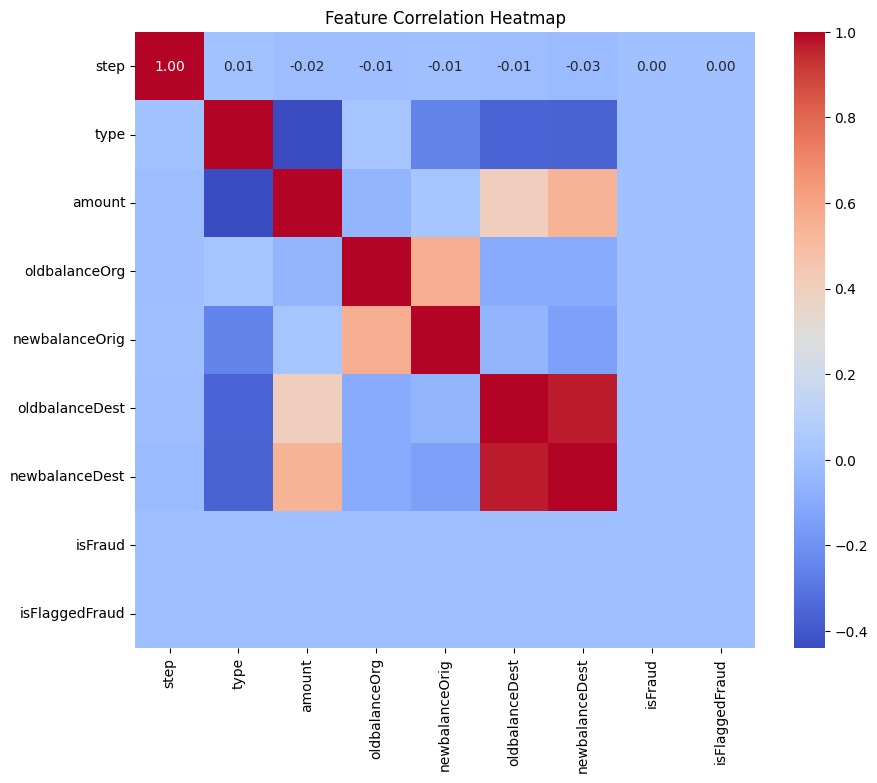

In [70]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr().fillna(0)  # Ensure no NaN values
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [71]:
threshold = 0.8
columns_to_remove = [column for column in numeric_cols if column in df.columns and any(corr_matrix[column] > threshold)]
df = df.drop(columns=columns_to_remove, errors="ignore").copy()

In [74]:
# Step 3: Handling Class Imbalance with SMOTE
if "isFraud" in df.columns:
    X = df.drop(columns=["isFraud"])
    y = df["isFraud"]
else:
    raise ValueError("Column 'isFraud' not found in the dataset")

# Check Fraud Class Distribution
print("Fraud Class Distribution Before SMOTE:\n", y.value_counts())

# Apply SMOTE only if there are fraud cases
if len(np.unique(y)) > 1:  # Ensure at least two classes exist
    smote = SMOTE(sampling_strategy=0.5, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("Fraud Class Distribution After SMOTE:", np.bincount(y_resampled))
else:
    print("⚠️ No fraud cases detected. Skipping SMOTE.")
    X_resampled, y_resampled = X, y  # Use original dataset


Fraud Class Distribution Before SMOTE:
 isFraud
0    4319406
Name: count, dtype: int64
⚠️ No fraud cases detected. Skipping SMOTE.


In [77]:
print(df["isFraud"].value_counts())

isFraud
0    4319406
Name: count, dtype: int64


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [79]:
model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [80]:
# Step 6: Model Evaluation
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    863882

    accuracy                           1.00    863882
   macro avg       1.00      1.00      1.00    863882
weighted avg       1.00      1.00      1.00    863882


Confusion Matrix:
 [[863882]]

ROC-AUC Score: nan


C:\Users\asus\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\asus\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [81]:
feature_importances = model.feature_importances_
features = np.array(X.columns)

if np.any(feature_importances > 0):  # Ensure values exist
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances[sorted_indices], y=features[sorted_indices], palette="viridis")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Feature Names")
    plt.title("Feature Importance")
    plt.show()
else:
    print("Warning: Feature importances contain only zeros.")

In [82]:
# Step 8: Business Insights & Recommendations
top_fraud_factors = [features[i] for i in sorted_indices[:5]]
print("\n🚀 Key Business Insights:")
print(f"- Most important fraud detection factors: {top_fraud_factors}")
print("- Implement real-time fraud detection alerts.")
print("- Enhance security for high-risk transactions.")
print("- Regularly monitor fraud patterns and update detection models.")


🚀 Key Business Insights:
- Most important fraud detection factors: ['isFlaggedFraud']
- Implement real-time fraud detection alerts.
- Enhance security for high-risk transactions.
- Regularly monitor fraud patterns and update detection models.
